# MNIST with SciKit-Learn and skorch

In [ ]:
import subprocess

# Installation on Google Colab
try:
    import google.colab
    subprocess.run(['python', '-m', 'pip', 'install', 'skorch' , 'torch'])
except ImportError:
    pass

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

## Loading Data

In [ ]:
mnist = fetch_openml('mnist_784', as_frame=False, cache=False)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [ ]:
mnist.data.shape

(70000, 784)

## Preprocessing Data


In [ ]:
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')

In [ ]:
X /= 255.0

In [ ]:
X.min(), X.max()

(0.0, 1.0)

Note: data is not normalized.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
assert(X_train.shape[0] + X_test.shape[0] == mnist.data.shape[0])

In [ ]:
X_train.shape, y_train.shape

((52500, 784), (52500,))

### Print a selection of training images and their labels

In [ ]:
def plot_example(X, y):
    """Plot the first 5 images and their labels in a row."""
    for i, (img, y) in enumerate(zip(X[:5].reshape(5, 28, 28), y[:5])):
        plt.subplot(151 + i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(y)

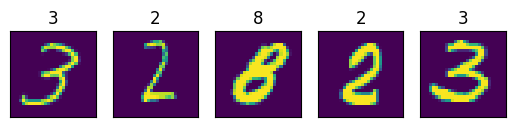

In [ ]:
plot_example(X_train, y_train)

## Build Neural Network with PyTorch

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
mnist_dim = X.shape[1]
hidden_dims = [int(mnist_dim/8)]
output_dim = len(np.unique(mnist.target))

In [ ]:
mnist_dim, hidden_dims, output_dim

(784, [98], 10)

In [ ]:
class ClassifierModule(nn.Module):
    def __init__(
            self,
            input_dim=mnist_dim,
            hidden_dims=hidden_dims,
            output_dim=output_dim,
            dropout=0.5,
    ):
        super(ClassifierModule, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.hidden = nn.ModuleList()
        for i in range(len(hidden_dims)):
            if i == 0:
              self.hidden.append(nn.Linear(mnist_dim, hidden_dims[i]))
            else:
              self.hidden.append(nn.Linear(hidden_dims[i - 1], hidden_dims[i]))
        self.output = nn.Linear(hidden_dims[-1], output_dim)

    def forward(self, X, eval=False, **kwargs):
        Ts = None
        layers = None
        layer_num = 0
        for h in self.hidden:
          X = F.relu(h(X))
          if eval:
            Ts = torch.cat((Ts, X), 1) if Ts is not None else X
            l = torch.ones_like(X) * layer_num
            layers = torch.cat((layers, l), 1) if layers is not None else l
          layer_num += 1
        X = self.dropout(X)
        X = F.softmax(self.output(X), dim=-1)
        if eval:
          return X, Ts, layers
        return X

In [ ]:
from skorch import NeuralNetClassifier
nets = []

In [ ]:
torch.manual_seed(0)

net1 = NeuralNetClassifier(
    ClassifierModule(mnist_dim, [100], output_dim),
    max_epochs=20,
    lr=0.1,
    device=device,
)

In [ ]:
net1.fit(X_train, y_train);
nets.append(net1)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.8367       0.8905        0.3961  1.7486
      2        0.4284       0.9098        0.3098  0.9710
      3        0.3556       0.9241        0.2624  0.9977
      4        0.3177       0.9331        0.2324  0.9628
      5        0.2917       0.9386        0.2125  0.9692
      6        0.2702       0.9412        0.1987  0.9295
      7        0.2533       0.9436        0.1900  0.9501
      8        0.2380       0.9490        0.1747  0.9978
      9        0.2291       0.9503        0.1688  0.9521
     10        0.2202       0.9527        0.1576  0.9669
     11        0.2106       0.9535        0.1554  1.1514
     12        0.2033       0.9557        0.1476  1.3004
     13        0.1999       0.9578        0.1457  1.1949
     14        0.1932       0.9564        0.1451  0.9763
     15        0.1892       0.9600        0.1360  0.9489
     16        0.1848       0.9

In [ ]:
y_pred = net1.predict(X_test)
accuracy_score(y_test, y_pred)

0.9621142857142857

In [ ]:
hidden_dims = [60, 40]
net2 = NeuralNetClassifier(ClassifierModule(mnist_dim, hidden_dims, output_dim), max_epochs=20, lr=0.1, device=device)
net2.fit(X_train, y_train);
nets.append(net2)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.1706       0.8329        0.5378  1.0481
      2        0.5422       0.9035        0.3359  0.9549
      3        0.4359       0.9195        0.2755  1.2858
      4        0.3662       0.9332        0.2221  1.3902
      5        0.3185       0.9320        0.2238  0.9877
      6        0.2814       0.9479        0.1776  0.9386
      7        0.2571       0.9503        0.1620  1.0259
      8        0.2357       0.9525        0.1567  0.9657
      9        0.2198       0.9533        0.1542  0.9892
     10        0.2045       0.9540        0.1585  0.9813
     11        0.1908       0.9580        0.1409  1.0089
     12        0.1804       0.9085        0.3134  1.0320
     13        0.1705       0.9638        0.1253  0.9535
     14        0.1628       0.9647        0.1231  1.0127
     15        0.1568       0.9615        0.1321  1.3752
     16        0.1489       0.9

In [ ]:
y_pred = net2.predict(X_test)
accuracy_score(y_test, y_pred)

0.9638857142857142

In [ ]:
hidden_dims = [40, 60]
net3 = NeuralNetClassifier(ClassifierModule(mnist_dim, hidden_dims, output_dim), max_epochs=20, lr=0.1, device=device)
net3.fit(X_train, y_train);
nets.append(net3)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.0867       0.8451        0.5136  1.1268
      2        0.5002       0.8920        0.3616  1.0863
      3        0.4027       0.9180        0.2784  1.0230
      4        0.3441       0.9276        0.2376  1.0112
      5        0.3032       0.9339        0.2172  1.0662
      6        0.2728       0.9455        0.1858  1.2488
      7        0.2463       0.9487        0.1705  1.3842
      8        0.2261       0.9511        0.1614  1.0777
      9        0.2104       0.9518        0.1599  1.0526
     10        0.1940       0.9530        0.1544  1.0277
     11        0.1852       0.9546        0.1497  1.0861
     12        0.1735       0.9570        0.1423  1.0315
     13        0.1664       0.9501        0.1662  1.0897
     14        0.1556       0.9524        0.1540  1.0204
     15        0.1496       0.9617        0.1261  1.0966
     16        0.1439       0.9

In [ ]:
y_pred = net3.predict(X_test)
accuracy_score(y_test, y_pred)

0.9594857142857143

In [ ]:
error_mask = y_pred != y_test

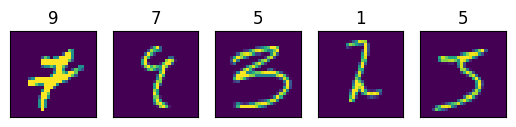

In [ ]:
plot_example(X_test[error_mask], y_pred[error_mask])

In [ ]:
hidden_dims = [50, 50]
net4 = NeuralNetClassifier(ClassifierModule(mnist_dim, hidden_dims, output_dim), max_epochs=20, lr=0.1, device=device)
net4.fit(X_train, y_train);
nets.append(net4)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.1529       0.8507        0.4999  1.0583
      2        0.5363       0.8800        0.3980  0.9885
      3        0.4292       0.9114        0.2959  1.5616
      4        0.3621       0.9236        0.2529  1.0230
      5        0.3189       0.9316        0.2209  1.0052
      6        0.2823       0.9324        0.2324  0.9790
      7        0.2563       0.9481        0.1748  0.9828
      8        0.2327       0.9514        0.1623  1.2443
      9        0.2211       0.9469        0.1770  1.3695
     10        0.2022       0.9552        0.1514  1.1123
     11        0.1892       0.9569        0.1460  0.9601
     12        0.1864       0.9536        0.1548  0.9743
     13        0.1776       0.9595        0.1422  0.9837
     14        0.1664       0.9607        0.1357  0.9722
     15        0.1596       0.9606        0.1355  1.0386
     16        0.1520       0.9

In [ ]:
y_pred = net4.predict(X_test)
accuracy_score(y_test, y_pred)

0.962

In [ ]:
hidden_dims = [20, 20, 20, 20, 20]
net5 = NeuralNetClassifier(ClassifierModule(mnist_dim, hidden_dims, output_dim), max_epochs=20, lr=0.1, device=device)
net5.fit(X_train, y_train);
nets.append(net5)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3024       0.1124        2.2996  1.5841
      2        2.2142       0.2776        1.9313  1.1536
      3        1.7942       0.3242        1.7891  1.2257
      4        1.3974       0.6199        1.2522  1.1488
      5        1.0226       0.8026        0.6843  1.1748
      6        0.8774       0.8546        0.6392  1.1284
      7        0.7901       0.8875        0.5380  1.1518
      8        0.7380       0.8857        0.5214  1.1374
      9        0.7001       0.8290        0.5950  1.2123
     10        0.6708       0.9125        0.4356  1.4985
     11        0.6476       0.9095        0.4308  1.5126
     12        0.6427       0.9194        0.3999  1.1226
     13        0.6147       0.8892        0.4670  1.2063
     14        0.6111       0.9275        0.3847  1.2206
     15        0.5902       0.9302        0.3966  1.1362
     16        0.5885       0.9

In [ ]:
y_pred = net5.predict(X_test)
accuracy_score(y_test, y_pred)

0.9320571428571428

In [ ]:
def get_correlation(module1, module2, X):
  Ts1, layers1 = module1.forward(X, eval=True)[1], module1.forward(X, eval=True)[2]
  Ts2, layers2 = module2.forward(X, eval=True)[1], module2.forward(X, eval=True)[2]

  correlations = np.zeros_like(Ts1.cpu().detach().numpy()[0])
  for i in range(Ts1.shape[1]):
    neuron_i = Ts1[:, i]
    max_idx = 0
    max_corr = -1
    for j in range(Ts2.shape[1]):
      neuron_j = Ts2[:, j]
      stacked = torch.stack((neuron_i, neuron_j))
      corr = torch.corrcoef(stacked)[0, 1] / (abs(layers1[0, i] - layers2[0, j]) + 1)
      corr = np.abs(corr.cpu().detach().numpy())
      if np.isnan(corr):
        corr = 0
      if corr > max_corr:
        max_corr = corr
        max_idx = j
    correlations[i] = max_corr

  return correlations.mean()

def mean_correlation(module1, module2, X):
    return (get_correlation(module1, module2, X) + get_correlation(module2, module1, X)) / 2

In [ ]:
for i in range(len(nets)):
  for j in range(i + 1, len(nets)):
    correlation = get_correlation(nets[i].module, nets[j].module, torch.tensor(X_test).to(device))
    print("correlation between net" + str(i + 1) + " and net" + str(j + 1) + ":", correlation)

correlation between net1 and net2: 0.6441813
correlation between net1 and net3: 0.6467914
correlation between net1 and net4: 0.6419462
correlation between net1 and net5: 0.5758694
correlation between net2 and net3: 0.69832456
correlation between net2 and net4: 0.69948316
correlation between net2 and net5: 0.5808465
correlation between net3 and net4: 0.73255426
correlation between net3 and net5: 0.5750158
correlation between net4 and net5: 0.5715857


# Convolutional Network


In [ ]:
class Cnn(nn.Module):
    def __init__(self, dropout=0.5):
        super(Cnn, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv2_drop = nn.Dropout2d(p=dropout)
        self.fc1 = nn.Linear(1600, 100) # 1600 = number channels * width * height
        self.fc2 = nn.Linear(100, 10)
        self.fc1_drop = nn.Dropout(p=dropout)

    def forward(self, x, eval=False):

        outputs = []
        x = x.reshape((x.shape[0], 1, 28, 28))

        x = torch.relu(F.max_pool2d(self.conv1(x), 2))
        outputs.append(x)
        x = torch.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        outputs.append(x)

        # flatten over channel, height and width = 1600
        x = x.view(-1, x.size(1) * x.size(2) * x.size(3))

        x = torch.relu(self.fc1_drop(self.fc1(x)))
        x = torch.softmax(self.fc2(x), dim=-1)

        Ts = None
        layers = None
        layer_num = 0
        if eval:
          for X in outputs:
            X = X.reshape((X.shape[0], np.prod(X.shape) // X.shape[0]))
            Ts = torch.cat((Ts, X), 1) if Ts is not None else X
            l = torch.ones_like(X) * layer_num
            layers = torch.cat((layers, l), 1) if layers is not None else l
            layer_num += 1
          return x, Ts, layers

        return x


In [ ]:
torch.manual_seed(0)

cnn = NeuralNetClassifier(
    Cnn(),
    max_epochs=10,
    lr=0.002,
    optimizer=torch.optim.Adam,
    device=device,
)

In [ ]:
cnn.fit(X_train, y_train);

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.4320       0.9723        0.0898  2.7209
      2        0.1646       0.9787        0.0683  1.4229
      3        0.1362       0.9827        0.0548  2.3759
      4        0.1157       0.9840        0.0497  1.4763
      5        0.1018       0.9849        0.0465  1.4988
      6        0.0968       0.9866        0.0406  1.4351
      7        0.0887       0.9867        0.0418  1.5579
      8        0.0864       0.9882        0.0381  1.8608
      9        0.0798       0.9886        0.0383  1.5326
     10        0.0749       0.9887        0.0363  1.4093


In [ ]:
y_pred = cnn.predict(X_test)
accuracy_score(y_test, y_pred)

0.9877714285714285

In [ ]:
for i in range(len(nets)):
  correlation = get_correlation(nets[i].module, cnn.module, torch.tensor(X_test[:10]).to(device))
  print("correlation between net" + str(i + 1) + " and cnn:", correlation)

correlation between net1 and cnn: 0.9211571
correlation between net2 and cnn: 0.9053279
correlation between net3 and cnn: 0.92999244
correlation between net4 and cnn: 0.8931049
correlation between net5 and cnn: 0.561959
